# DK - Derman Kani Binomial Tree Model

> Author: Gustavo Monteiro de Athayde  
> Monitor: Sylvio Ximenez de Azevedo Neto - <<sylvioxan@insper.edu.br>>  
> Date: 22/03/2025

In [1]:
# dependencies
from lib import derivatives as dg               # course library
from lib import derivatives_binomial as bm      # course library
from scipy.stats import norm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [19]:
# parameters
S0 = 100
K = 100
rf = 0.02
T = 1
vol = 0.402704657663518
sigma = 40

bs = dg.bs_call_option(S0, K, T, rf, vol)

bs_true = np.exp(-rf*T) * ((S0 * np.exp(rf*T)-S0) * norm.cdf((S0 * np.exp(rf*T)-S0)/(sigma*np.sqrt(T))) + (sigma * np.sqrt(T) * norm.pdf((S0 * np.exp(rf*T)-S0)/(sigma*np.sqrt(T)))))

error_quad = np.log((bs/bs_true))**2*99999

In [20]:
error_quad

np.float64(8.836205758654334)

In [22]:
ccr_prices = bm.calc_spot_tree(S0, vol, T, 4)
ccr_prices

,0,1,2,3,4
0,100.0,122.305561,149.586503,182.952613,223.761220
1,NaN,81.762431,100.000000,122.305561,149.586503
2,NaN,NaN,66.850951,81.762431,100.000000
3,NaN,NaN,NaN,54.658963,66.850951
4,NaN,NaN,NaN,NaN,44.690496


In [27]:
def traverse_all_paths(df):
    paths = []
    def traverse_path(i, j, path):
        if i >= df.shape[0] or j >= df.shape[1] or pd.isna(df.iloc[i, j]):
            return
        path.append(df.iloc[i, j])
        if j == df.shape[1] - 1:
            paths.append(path.copy())
        else:
            traverse_path(i, j + 1, path)
            traverse_path(i + 1, j + 1, path)
        path.pop()

    traverse_path(0, 0, [])
    return pd.DataFrame(paths)


ccr_paths = traverse_all_paths(ccr_prices)

In [28]:
ccr_paths

,0,1,2,3,4
0,100.0,122.305561,149.586503,182.952613,223.761220
1,100.0,122.305561,149.586503,182.952613,149.586503
2,100.0,122.305561,149.586503,122.305561,149.586503
3,100.0,122.305561,149.586503,122.305561,100.000000
4,100.0,122.305561,100.000000,122.305561,149.586503
5,100.0,122.305561,100.000000,122.305561,100.000000
6,100.0,122.305561,100.000000,81.762431,100.000000
7,100.0,122.305561,100.000000,81.762431,66.850951
8,100.0,81.762431,100.000000,122.305561,149.586503
9,100.0,81.762431,100.000000,122.305561,100.000000


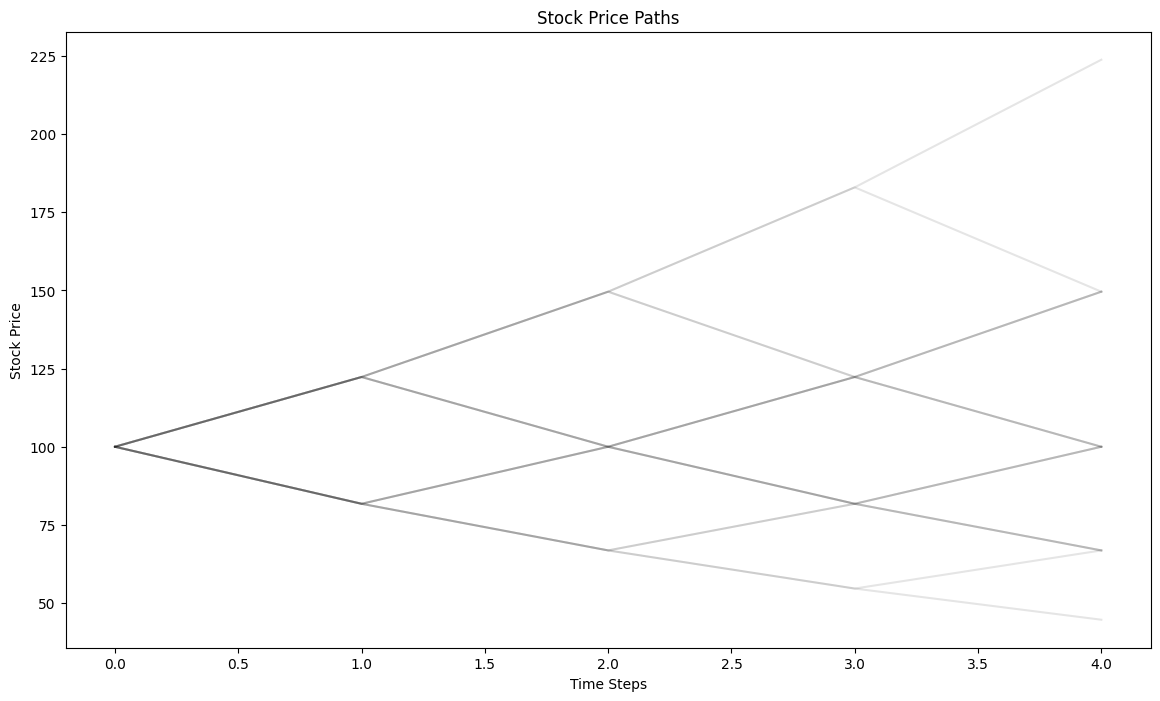

In [29]:
# plot the paths
plt.figure(figsize=(14, 8))
for i in range(ccr_paths.shape[0]):
    plt.plot(ccr_paths.columns, ccr_paths.iloc[i, :], color='black', alpha=0.1)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('Stock Price Paths')
plt.show()

In [142]:
def prob_tree(S0, vol, T, steps):

    prob = bm.calc_probability(rf, 0, vol, T, steps)

    df = pd.DataFrame(index=range(steps+1), columns=range(steps+1))
    
    for i in range(steps):
        for j in range(i+1):
            df.iloc[j, i] = prob

    return df

prob = prob_tree(S0, vol, T, 4)

def arrow_debreu_tree(prob, rf, T):    

    # df filled with 0    
    df = pd.DataFrame(np.zeros((prob.shape[0], prob.shape[1])))
    
    df.iloc[0, 0] = 1

    # replace prob nan to zeros
    prob = prob.fillna(0)

    for j in range(1, prob.shape[0]):
        df.iloc[0, j] = (df.iloc[0, j-1] * prob.iloc[0, j-1]) * np.exp(-rf*T/4)

    for i in range(1, prob.shape[0]):
        for j in range(i, prob.shape[0]):
            df.iloc[i, j] = (df.iloc[i-1, j-1] * (1-prob.iloc[i-1, j-1]) + df.iloc[i, j-1] * prob.iloc[i, j-1]) * np.exp(-rf*T/4)
            
    return df

ad = arrow_debreu_tree(prob, rf, T)

C:\Users\sazevedo\AppData\Local\Temp\ipykernel_46540\555110338.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prob = prob.fillna(0)


In [143]:
prob

,0,1,2,3,4
0,0.462195,0.462195,0.462195,0.462195,NaN
1,NaN,0.462195,0.462195,0.462195,NaN
2,NaN,NaN,0.462195,0.462195,NaN
3,NaN,NaN,NaN,0.462195,NaN
4,NaN,NaN,NaN,NaN,NaN


In [144]:
ad

,0,1,2,3,4
0,1.0,0.459890,0.211498,0.097266,0.044732
1,0.0,0.535123,0.492195,0.339533,0.208197
2,0.0,0.000000,0.286357,0.395077,0.363384
3,0.0,0.000000,0.000000,0.153236,0.281886
4,0.0,0.000000,0.000000,0.000000,0.082000


### Derman-Kani Tree

In [169]:
def call(S0, prev_price, rf, T, step, steps):
    return np.exp(-rf*T*step/steps) * (((S0 * np.exp(rf*T*step/steps))-prev_price) * norm.cdf((S0 * np.exp(rf*T*step/steps)-prev_price)/(sigma*np.sqrt(T*step/steps))) + (sigma * np.sqrt(T*step/steps) * norm.pdf((S0 * np.exp(rf*T*step/steps)-prev_price)/(sigma*np.sqrt(T*step/steps)))))

def derman_kani_tree(S0, rf, sigma, T, steps):

    # allocate price tree dataframe
    df = pd.DataFrame(index=range(steps+1), columns=range(steps+1))

    # allocate call/put tree dataframe
    cp = pd.DataFrame(index=range(steps+1), columns=range(steps+1))

    # allocate probability tree dataframe
    prob = pd.DataFrame(index=range(steps+1), columns=range(steps+1))

    # allocate arrow-debreu tree dataframe
    ad = pd.DataFrame(index=range(steps+1), columns=range(steps+1))

    df.iloc[0, 0] = S0
    cp.iloc[0, 1] = call(S0, S0, rf, T, 1, steps)
    ad.iloc[0, 0] = 1

    # calculate the spot price tree and call/put tree
    for i in range(1, steps+1):
        for j in range(i+1):
            
            prev_price = df.iloc[j, i-1]
            call_price = cp.iloc[j, i]
            prev_ad = ad.iloc[j, i-1]

            df.iloc[j, i] = prev_price * (call_price * np.exp(rf*T/steps) + prev_ad * prev_price) / (prev_ad * prev_price * np.exp(rf*T/steps) - call_price * np.exp(rf*T/steps))

            if i < steps+1:
                cp.iloc[j, i+1] = call(S0, df.iloc[j, i], rf, T, i+1, steps)                


    return df, cp

In [171]:
df, cp = derman_kani_tree(S0, rf, sigma, T, 4)

IndexError: iloc cannot enlarge its target object